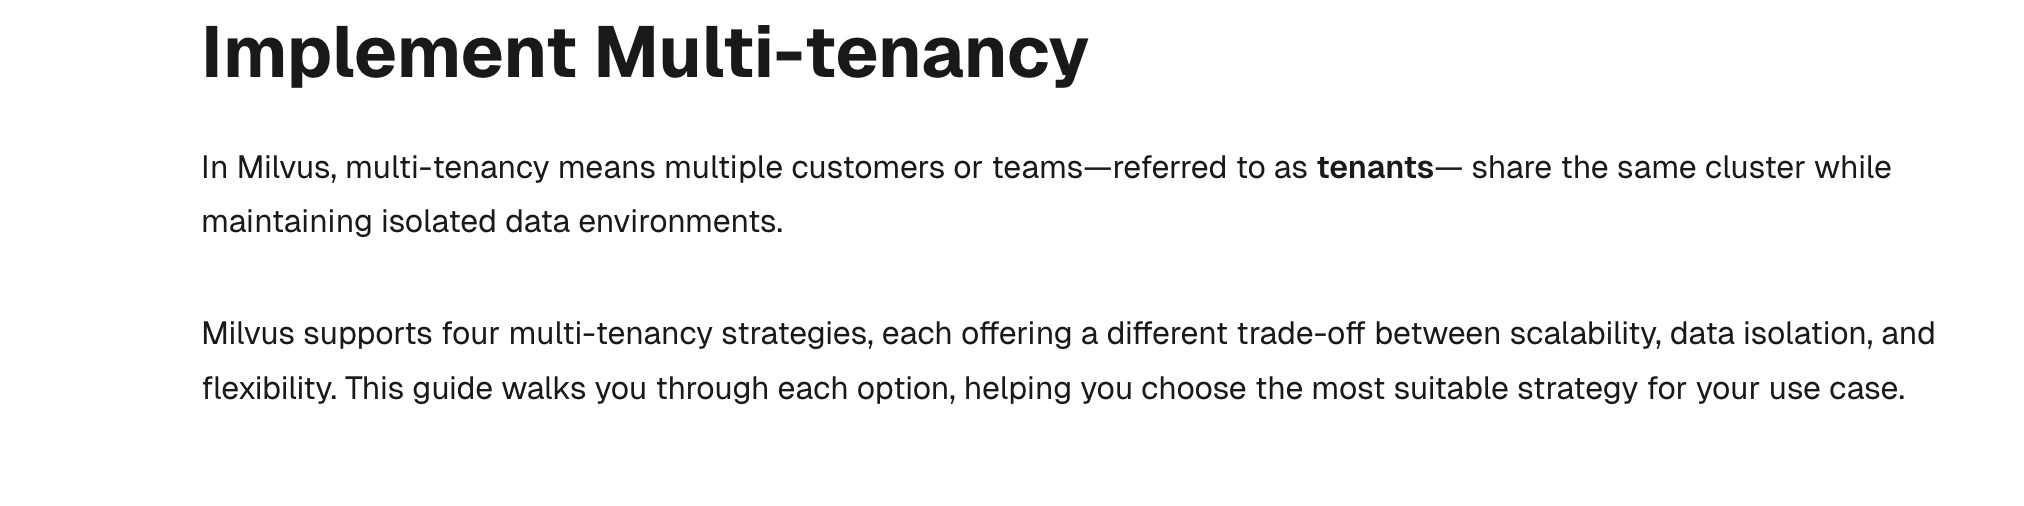

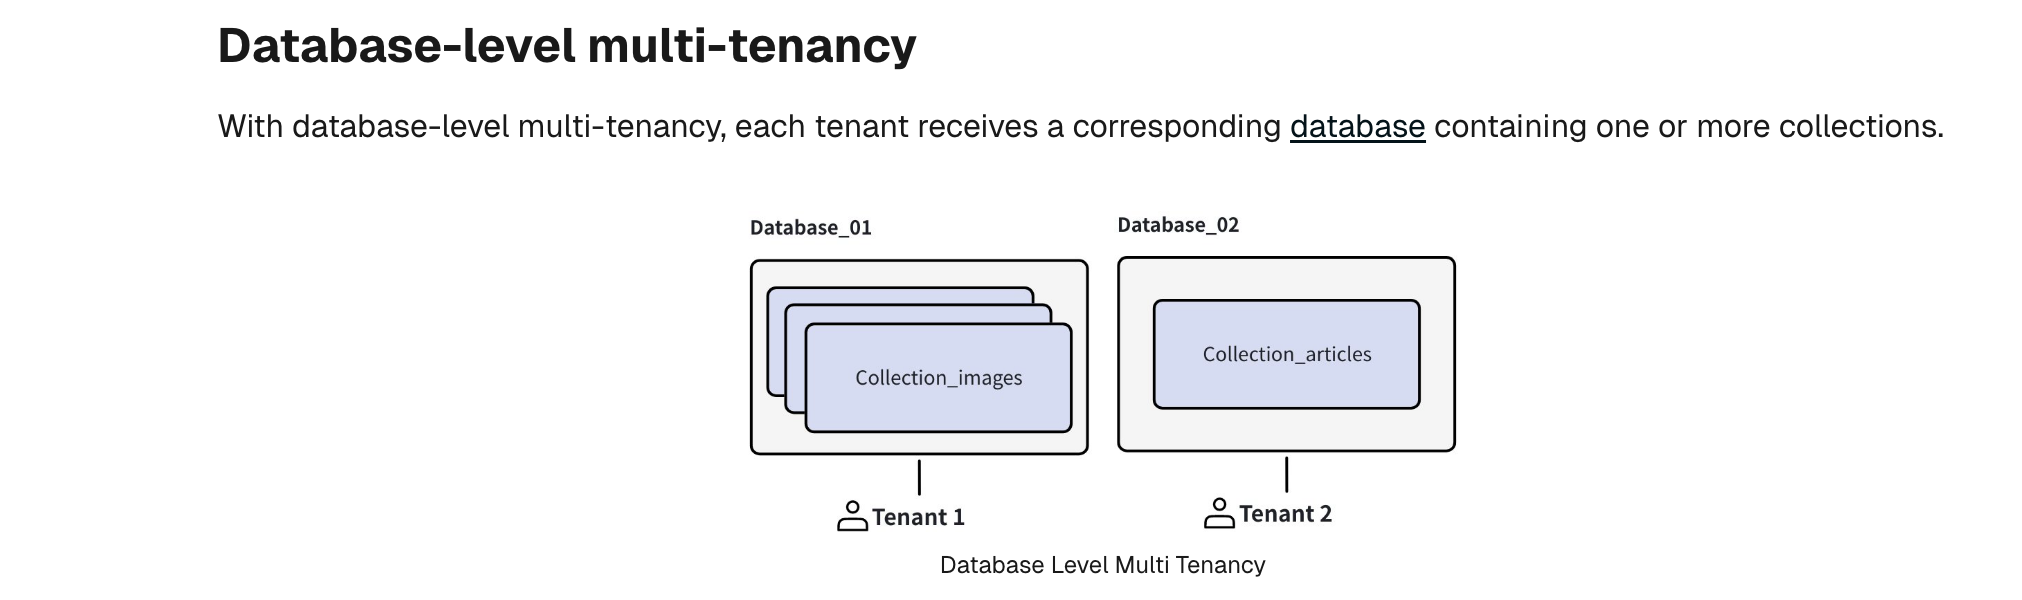

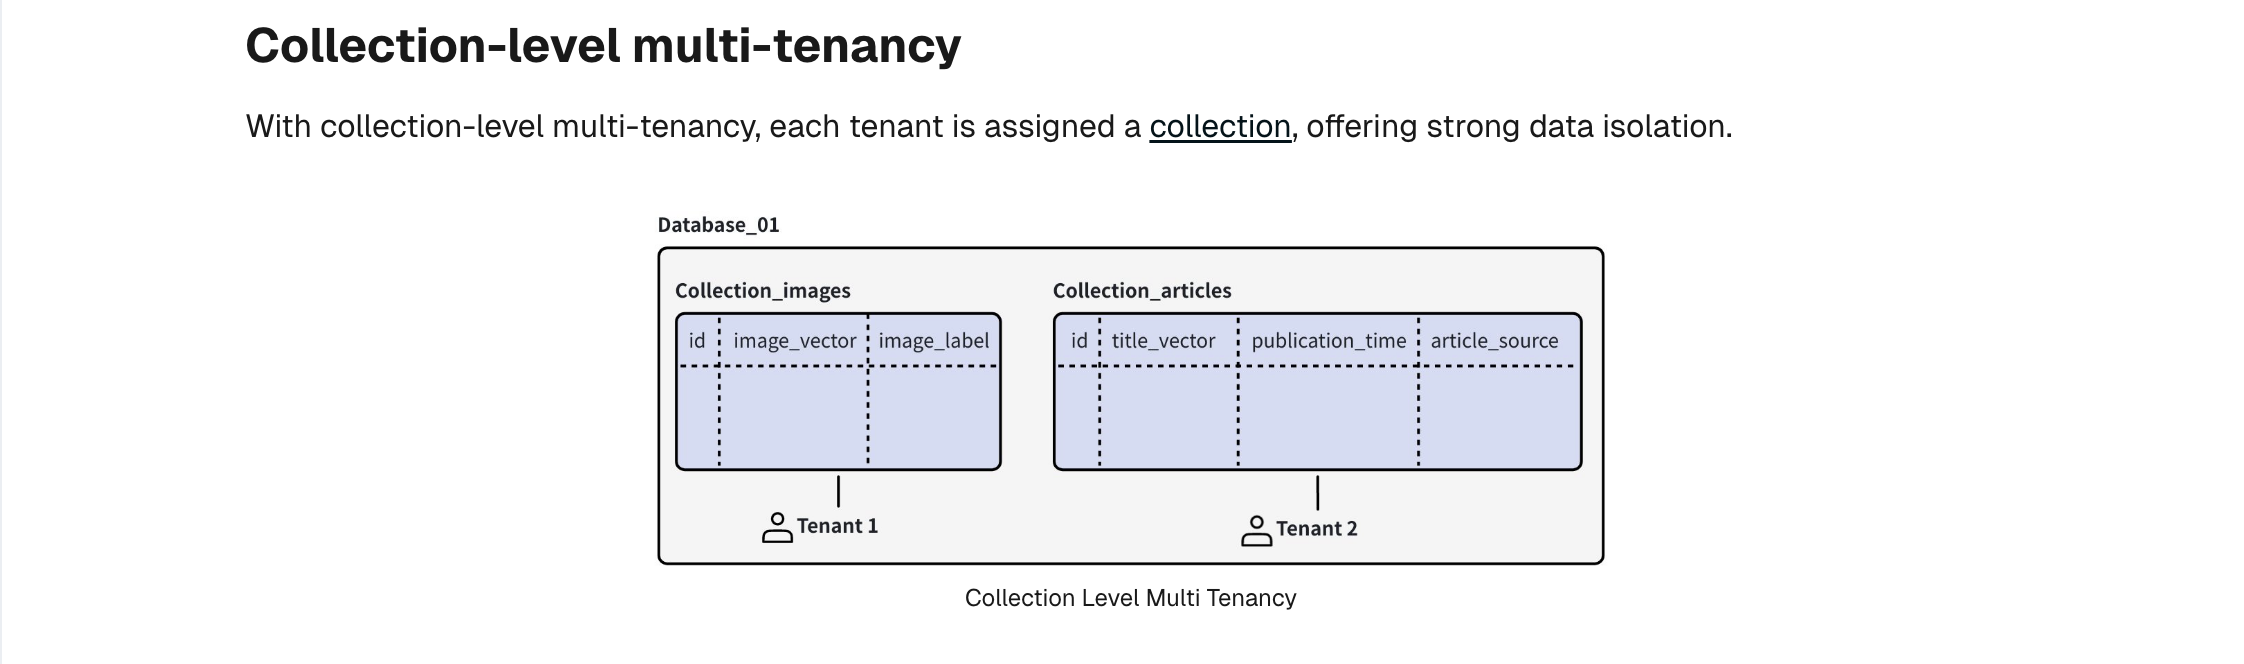

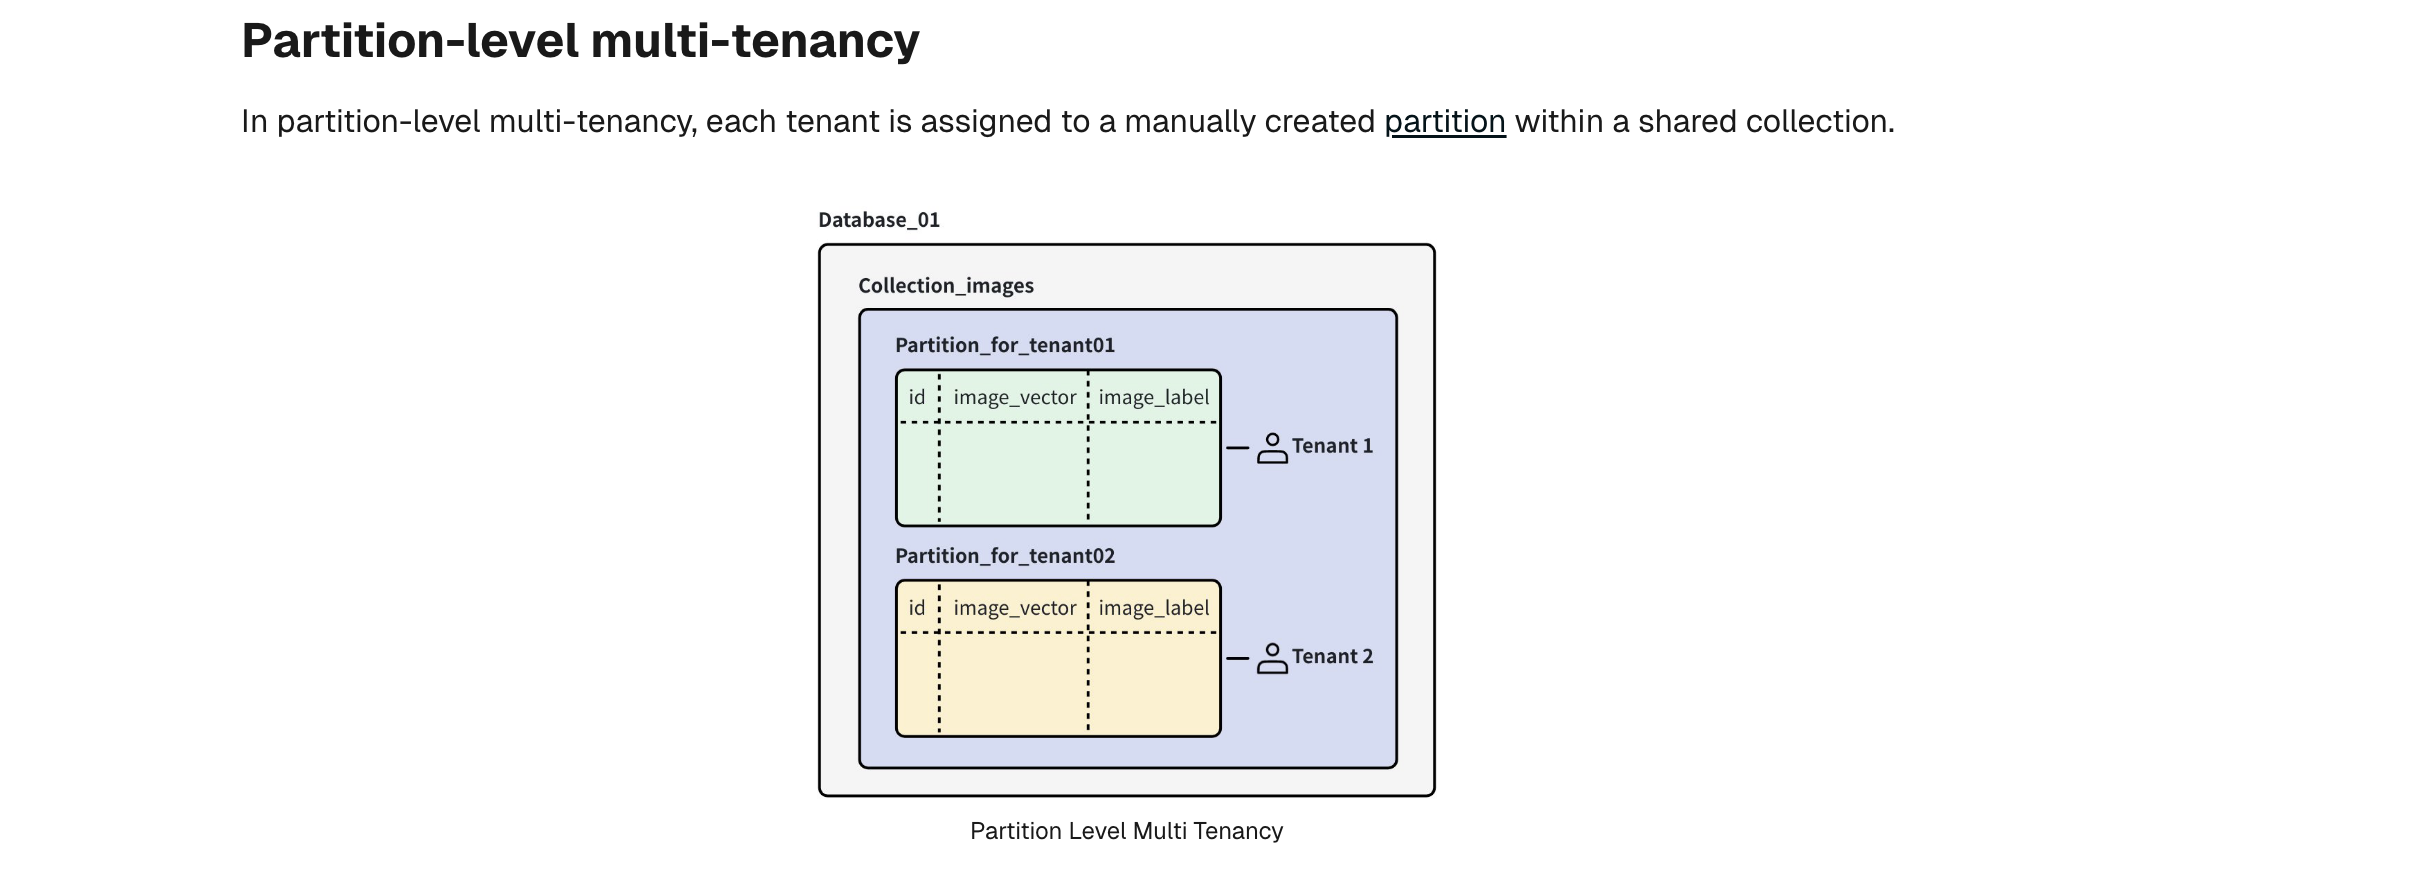

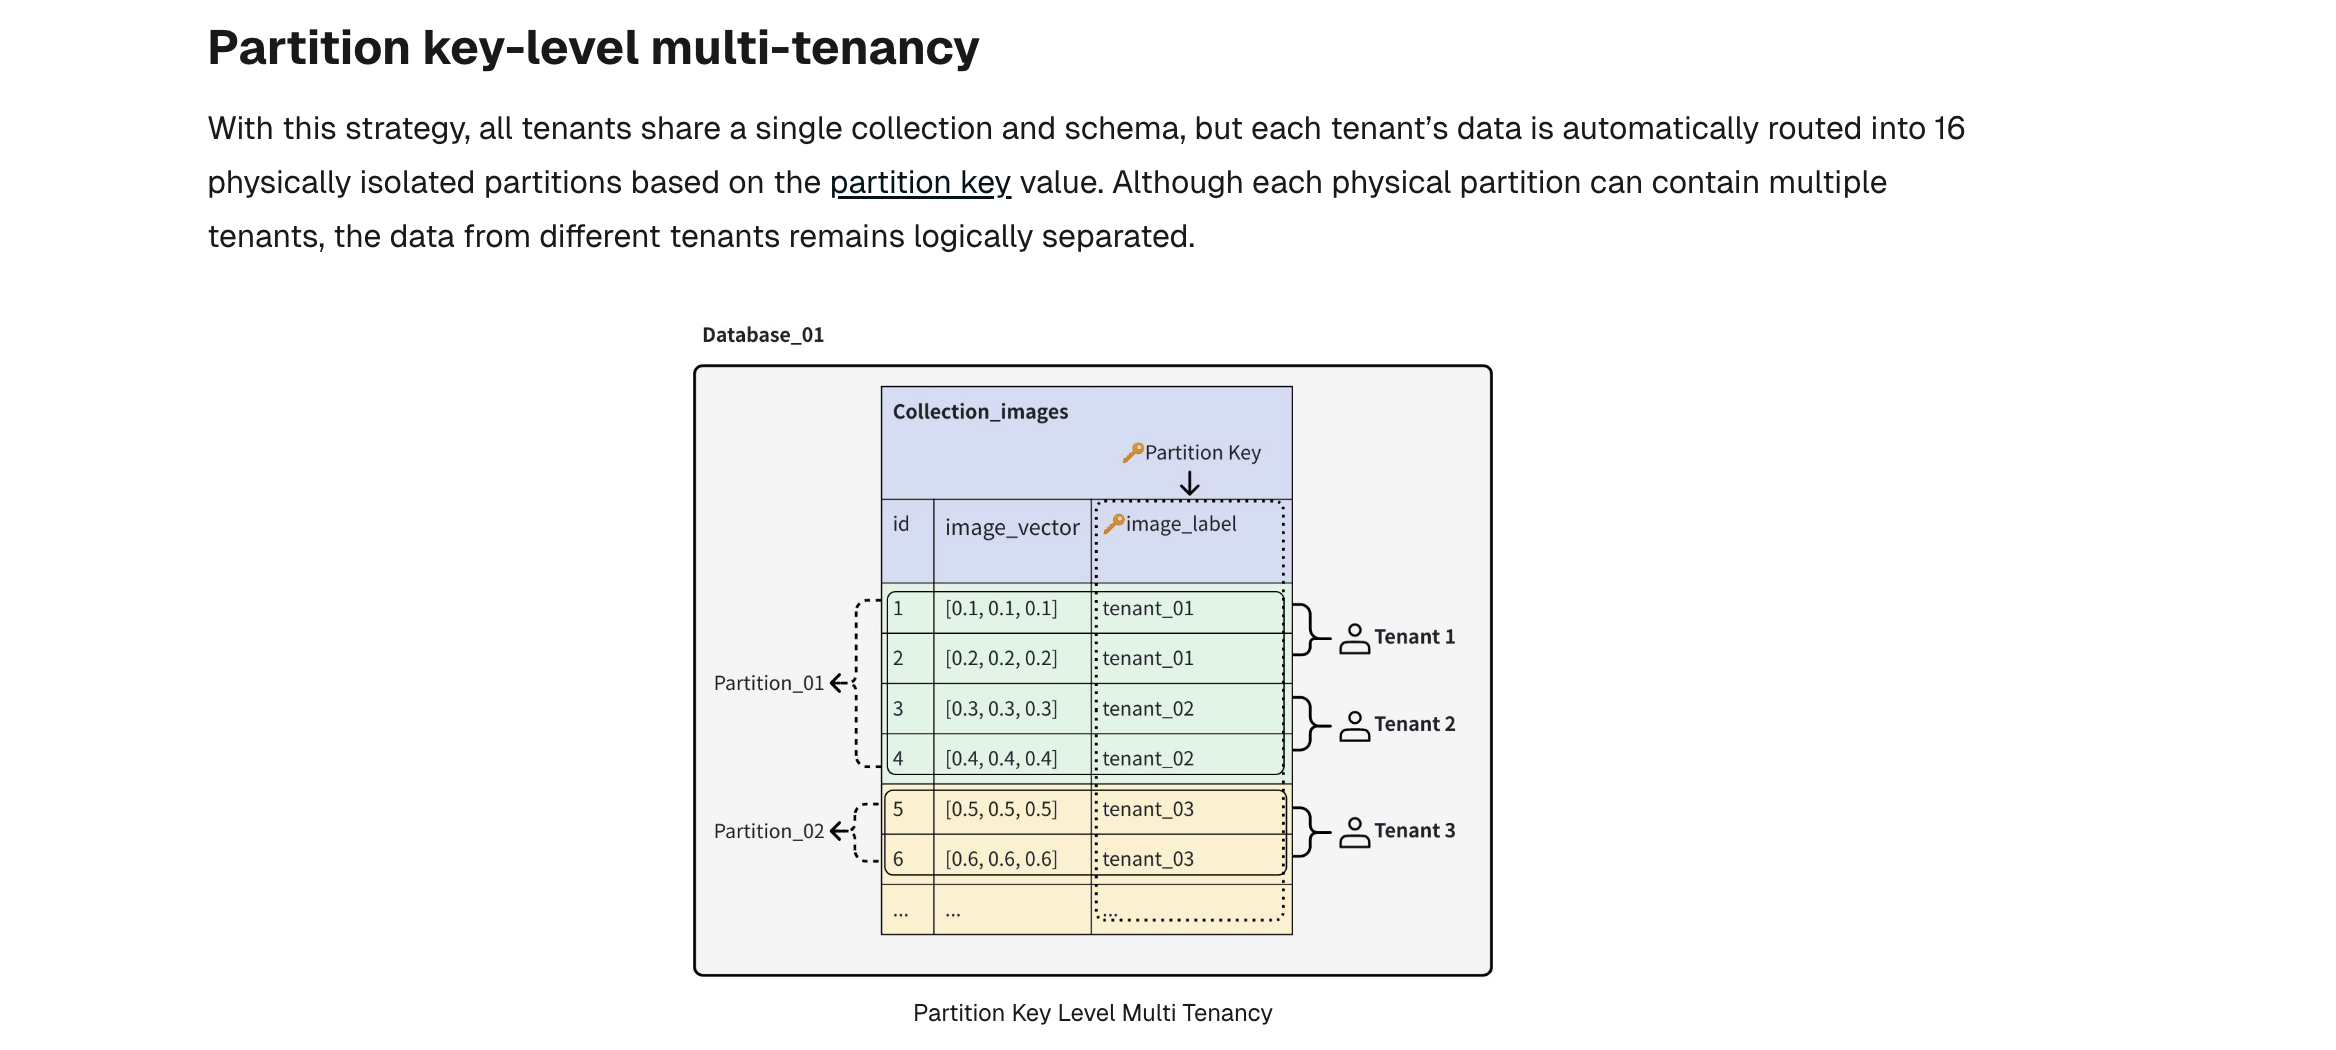

https://milvus.io/docs/multi_tenancy.md

In [1]:
import os
from typing import List, Dict

from pymilvus import MilvusClient, DataType
from sentence_transformers import SentenceTransformer
from pypdf import PdfReader
from dotenv import load_dotenv
load_dotenv()

# ========= CONFIGURATION =========

# Set these as environment variables OR hard-code (not recommended)
MILVUS_HOST = os.getenv("MILVUS_HOST")        # gRPC host from watsonx.data Milvus service
MILVUS_PORT = os.getenv("MILVUS_PORT", "443") # gRPC port from service
MILVUS_API_KEY = os.getenv("MILVUS_API_KEY")  # IBM Cloud API key

# # Paths to your PDFs
# PUBLIC_PDF_PATH = "./data/offerings_public.pdf"
# MANAGERS_PDF_PATH = "./data/offerings_managers_only.pdf"

# Collection names
PUBLIC_COLLECTION = "offerings_public"
MANAGERS_COLLECTION = "offerings_managers_only"

# Embedding model (384 dimensions)
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
EMBEDDING_DIM = 384  # fixed for this model

# print(MILVUS_HOST)
# print(MILVUS_PORT)
# print(MILVUS_API_KEY)

/Users/michal/anaconda3/envs/milvus/lib/python3.11/site-packages/pymilvus/client/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/michal/anaconda3/envs/milvus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def connect_milvus() -> MilvusClient:
    if not (MILVUS_HOST and MILVUS_PORT and MILVUS_API_KEY):
        raise RuntimeError("Set MILVUS_HOST, MILVUS_PORT and MILVUS_API_KEY first.")
	

    milvus_uri = f"https://ibmlhapikey_michal.kordyzon@pl.ibm.com:{MILVUS_API_KEY}@{MILVUS_HOST}:{MILVUS_PORT}"

    client = MilvusClient(
        uri=milvus_uri,
        secure=True,
    )
    return client


In [3]:
from typing import List, Dict

def _semantic_search_collection(
    client,
    model,
    collection_name: str,
    query: str,
    top_k: int = 5,
    output_fields: List[str] | None = None,
) -> List[Dict]:
    """
    Generic semantic search over any Milvus collection.
    """
    if output_fields is None:
        output_fields = ["offering_id", "text"]

    # 1. Ensure collection is loaded
    client.load_collection(collection_name)

    # 2. Embed the query
    query_vec = model.encode([query], convert_to_numpy=True)[0].tolist()

    # 3. Search parameters
    search_params = {
        "metric_type": "COSINE",  # must match index metric
        "params": {}              # FLAT index → no extra params
    }

    # 4. Search in Milvus
    results = client.search(
        collection_name=collection_name,
        data=[query_vec],
        anns_field="embedding",
        limit=top_k,
        output_fields=output_fields,
        search_params=search_params,
    )

    hits = results[0]

    formatted: List[Dict] = []
    for hit in hits:
        entity = hit.get("entity", {})
        formatted.append(
            {
                "id": hit["id"],
                "score": hit["distance"],              # COSINE distance; lower = closer
                "offering_id": entity.get("offering_id"),
                "text": entity.get("text", ""),
            }
        )

    return formatted


In [4]:
def semantic_search_public(
    client,
    model,
    query: str,
    top_k: int = 5,
) -> List[Dict]:
    """
    Semantic search over the public collection.
    """
    return _semantic_search_collection(
        client=client,
        model=model,
        collection_name=PUBLIC_COLLECTION,
        query=query,
        top_k=top_k,
    )


In [5]:
def semantic_search_private(
    client,
    model,
    query: str,
    top_k: int = 5,
) -> List[Dict]:
    """
    Semantic search over the private/manager collection.
    """
    return _semantic_search_collection(
        client=client,
        model=model,
        collection_name=MANAGERS_COLLECTION,
        query=query,
        top_k=top_k,
    )


In [6]:
role = "employee"
#role = "manager"
query = "TravelFlex"

In [7]:
def run_demo(role, query):
    # 0. Connect once and load model once
    client = connect_milvus()
    print("Connected to IBM Milvus.")

    print("Loading embedding model (if not already loaded)...")
    model = SentenceTransformer(EMBEDDING_MODEL_NAME)

    # 1. Naive role detection
    # role = input("Are you an employee or manager? ").strip().lower()

    # 2. Ask for semantic query
    # query = input("What do you want to search for? ").strip()

    if role == "manager":
        print("\n[Manager mode → PRIVATE collection]")
        results = semantic_search_private(
            client=client,
            model=model,
            query=query,
            top_k=5,
        )
    else:
        # treat everything else as common/regular user
        print("\n[Employee/common user mode → PUBLIC collection]")
        results = semantic_search_public(
            client=client,
            model=model,
            query=query,
            top_k=5,
        )

    # 3. Display results
    print(f"\nTop results for query: {query!r}")
    for i, r in enumerate(results, 1):
        print("\n---- Result", i, "----")
        print("Score      :", r["score"])
        print("ID         :", r["id"])
        print("Offering ID:", r["offering_id"])
        print("Text       :", r["text"][:400], "...")

In [8]:
run_demo(role, query)

Connected to IBM Milvus.
Loading embedding model (if not already loaded)...

[Employee/common user mode → PUBLIC collection]

Top results for query: 'TravelFlex'

---- Result 1 ----
Score      : 0.3046700060367584
ID         : 462349868925426229
Offering ID: offering_xyz
Text       : FintechNova – Token-Based Insurance Portfolio (Public Overview) FintechNova is introducing a next-generation suite of token-based insurance products designed for digital-first customers who value transparency, automation, and rapid claim settlement. All products are built on our proprietary NovaChain technology, which enables secure token issuance, premium automation, and instant micro-payouts usi ...

---- Result 2 ----
Score      : 0.10666397958993912
ID         : 462349868925426230
Offering ID: offering_xyz
Text       : Safe driving → lower premiums and bonus tokens. • Immediate damage assessment using AI incident detection. • Smart roadside assistance: Request support directly through your token wallet

In [9]:
# ##################
# role: manager
# ##################

# onnected to IBM Milvus.
# Loading embedding model (if not already loaded)...

# [Manager mode → PRIVATE collection]

# Top results for query: 'TravelFlex'

# ---- Result 1 ----
# Score      : 0.17749696969985962
# ID         : 462191026211244782
# Offering ID: offering_xyz
# Text       : FintechNova – Internal Strategy, Revenue Model, Costs & Risks for Token-Based Insurance Portfolio Confidential – For Managers Only This document outlines the internal financials, strategy, operational risks, and cost structure behind FintechNova’s new token-based insurance product line. Information contained here must not be shared with non-managerial staff or external parties. 1. Strategic Object ...

# ---- Result 2 ----
# Score      : 0.1629544496536255
# ID         : 462191026211244784
# Offering ID: offering_xyz
# Text       : emerge). • Customer backlash to automated decisioning. 6. Three-Year Competitive Advantages • First-mover advantage in modular token insurance. • NovaChain throughput (32,000 tx/s) gives strong scalability. • Deep AI integration improves underwriting accuracy. • Extremely short payout latency (< 2 seconds average). 7. Internal Recommendations 1. Prioritize HealthShield + TravelFlex expansion—highe ...

# ---- Result 3 ----
# Score      : 0.12633204460144043
# ID         : 462191026211244783
# Offering ID: offering_xyz
# Text       : • Partnership with MediScan reduces verification time by 43%. AutoSafe • Margin highly dependent on quality of driving-score telemetry. • High initial hardware integration cost. • Segment has highest upsell potential → driver rewards, fleet analytics. HomeGuard • Smart-home sensor integration reduces risk significantly. • Margin target: 19%. • Major risk: false positives triggering unnecessary tok ...


In [10]:
# # ##################
# # role: employee
# # ##################
# [Employee/common user mode → PUBLIC collection]

# Top results for query: 'TravelFlex'

# ---- Result 1 ----
# Score      : 0.3046700060367584
# ID         : 462349868925426229
# Offering ID: offering_xyz
# Text       : FintechNova – Token-Based Insurance Portfolio (Public Overview) FintechNova is introducing a next-generation suite of token-based insurance products designed for digital-first customers who value transparency, automation, and rapid claim settlement. All products are built on our proprietary NovaChain technology, which enables secure token issuance, premium automation, and instant micro-payouts usi ...

# ---- Result 2 ----
# Score      : 0.10666397958993912
# ID         : 462349868925426230
# Offering ID: offering_xyz
# Text       : Safe driving → lower premiums and bonus tokens. • Immediate damage assessment using AI incident detection. • Smart roadside assistance: Request support directly through your token wallet. Target Users: Urban drivers, fleet owners, low-mileage drivers. 4. HomeGuard Token Insurance Purpose: Tokenized home insurance with transparent event-based coverage. Key Features: • Event Tokens: Theft token, wat ...
